**Exploratory Analysis**

First we load in the packages that will need to later use.

In [4]:
library(repr)
library(tidyverse)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6, repr.plot.width = 12, repr.plot.height = 10)

── Attaching core tidyverse packages ──────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ────────────────────────────────────────

We read the raw heart disease data from the web.

In [5]:
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), 
                       col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
                                     "slope", "ca", "thal", "num"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Now we select the columns that we may potentialy use as predictors for our classification model. These columns are age, resting blood pressure, serum cholesterol, maximum heart rate achieved, and ST depression from excercise (refer to the introduction for further information). The reason we select these variables is because they are numeric. Variables that are categorical are usually not good predictors for classification models as the data distruibution is not smooth. We mutate all cases where num > 0 to 1 as we simply want to determine if the patient has heart disease and not what stage of heart disease it is.

In [6]:
heart_selected <- select(heart_data, age, trestbps, chol, thalach, oldpeak, num) |>
    mutate(num = case_when(num > 0 ~ 1, num == 0 ~ 0))
heart_selected

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,150,2.3,0
67,160,286,108,1.5,1
67,120,229,129,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,1
57,130,236,174,0.0,1
38,138,175,173,0.0,0


Splitting training and testing data.

In [7]:
heart_split <- initial_split(heart_selected, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Exploratory analysis of the number of observations and mean values of each class.

In [8]:
heart_sum <- heart_train |> 
    group_by(num) |> 
    summarize(count = n(), mean_age = mean(age), mean_trestbps = mean(trestbps), 
              mean_chol = mean(chol), mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak))
heart_sum

num,count,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,123,51.73171,129.3984,240.8862,160.3008,0.5674797
1,104,56.90385,135.3365,248.4615,140.1731,1.5730769


We use ggplot to make histograms in order to vizualize the distribution of each potential predictor. We then use the plot_grid function from the cowplot package to merge all histograms into a single plot as well as add a title.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


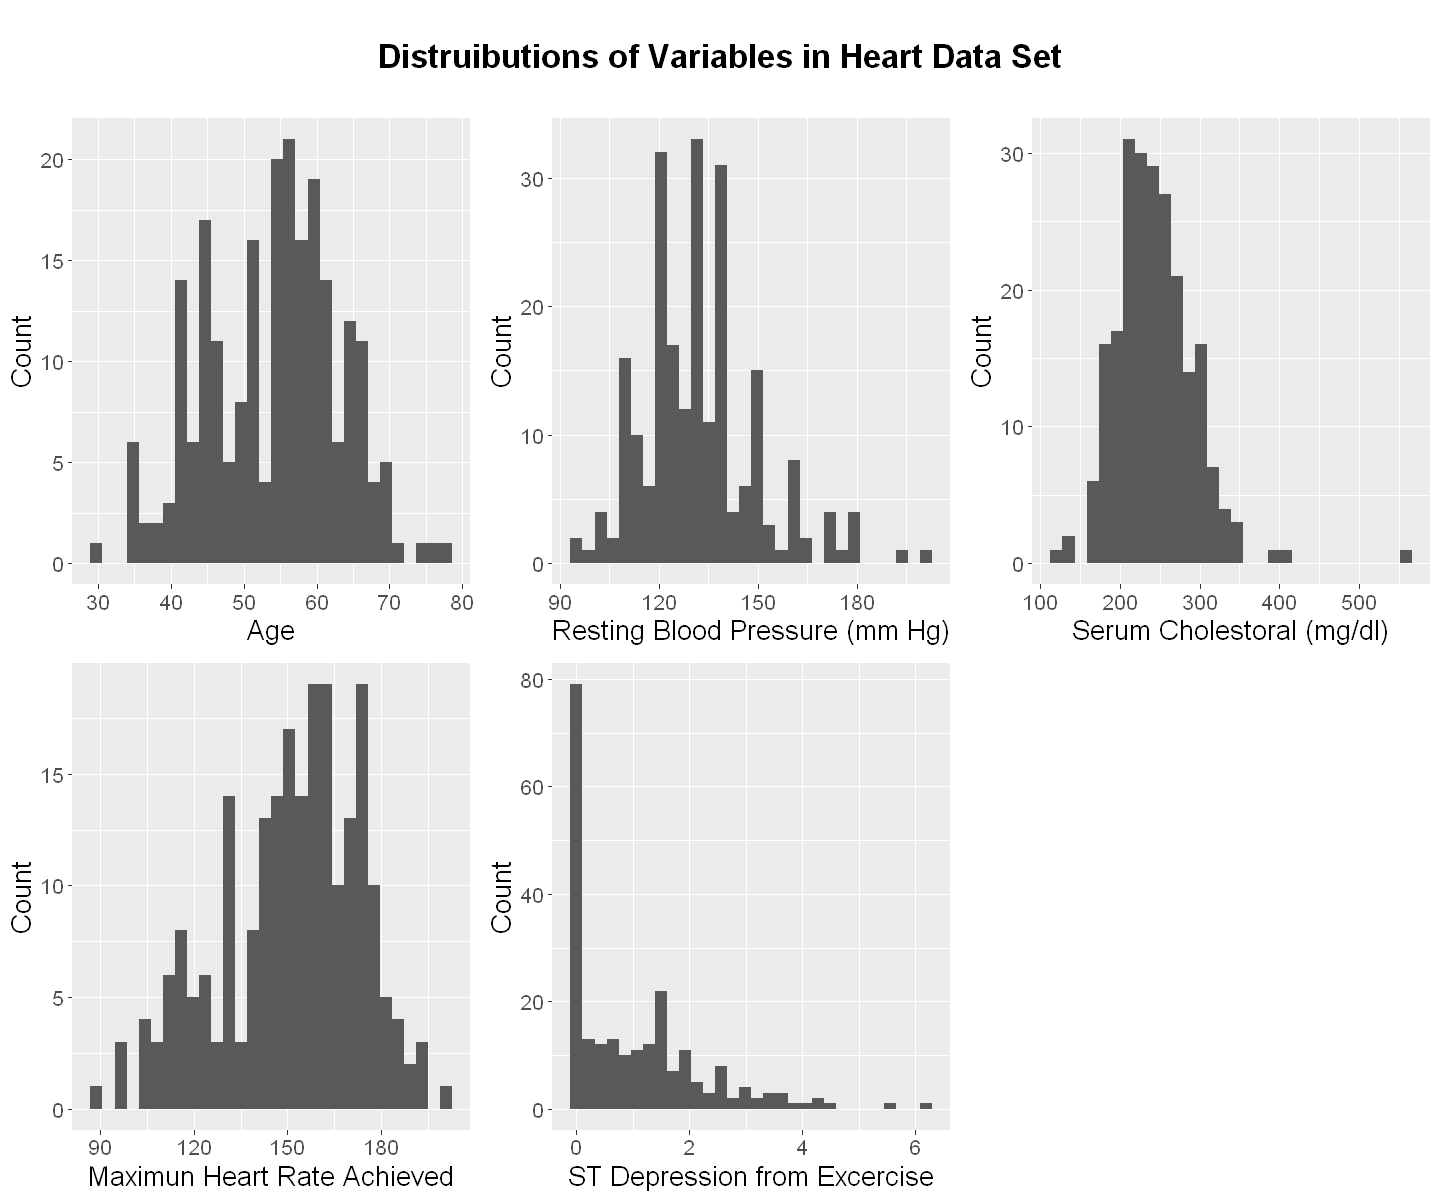

In [23]:
age_hist <- ggplot(heart_train, aes(x = age)) +
    geom_histogram() +
    labs(x = "Age", y = "Count") +
    theme(text = element_text(size=16))
trestbps_hist <- ggplot(heart_train, aes(x = trestbps)) +
    geom_histogram() +
    labs(x = "Resting Blood Pressure (mm Hg)", y = "Count") +
    theme(text = element_text(size=16)) 
chol_hist <- ggplot(heart_train, aes(x = chol)) +
    geom_histogram() +
    labs(x = "Serum Cholestoral (mg/dl)", y = "Count") +
    theme(text = element_text(size=16))
thalach_hist <- ggplot(heart_train, aes(x = thalach)) +
    geom_histogram() +
    labs(x = "Maximun Heart Rate Achieved", y = "Count") +
    theme(text = element_text(size=16))
oldpeak_hist <- ggplot(heart_train, aes(x = oldpeak)) +
    geom_histogram() +
    labs(x = "ST Depression from Excercise", y = "Count") +
    theme(text = element_text(size=16))
title <- ggdraw() + draw_label("Distruibutions of Variables in Heart Data Set", fontface='bold', size = 20)
heart_hist <- plot_grid(age_hist, trestbps_hist, chol_hist, thalach_hist, oldpeak_hist)
heart_hist_title <- plot_grid(title, heart_hist, ncol=1, rel_heights=c(0.1, 1))
heart_hist_title